# MS5001 Group Project

#### **Done by:**
TANG WEN YUE; e0920872@u.nus.edu  
ZHANG SHUANG; e1582514@u.nus.edu  
GAN LEA WAH IVOR; e1538123@u.nus.edu  
GAN ZHENG WEI, TIMOTHY; e1561523@u.nus.edu  

#### **Chosen dataset:**
Airline Sentiments

USE PYTHON 3.12!!!!

This section imports all the required libraries. For convenience and organisation, the libraries are imported at the top section of this notebook.

Note: Requires Jupyter Extension 2025.8.0 in VS Code due to a bug of Python 3.14 running in virtual environments.
https://github.com/microsoft/vscode-jupyter/issues/17042 [Not relevant anymore since we are using Python 3.12]

In [145]:
#Import libraries
import pandas as pd
import re
import emoji
import random
import numpy as np

#The emot library includes emoticons, eg. :), :D which are not supported by the emoji library
import emot

from tqdm import tqdm
tqdm.pandas()  # Enable progress bar for pandas apply functions

## Section 1: Data Exploration

In this step, we import the data into a pandas dataframe and perform some exploratory data analysis to get a brief initial look at the dataset.

In [3]:
#Import data into a pandas dataframe
tweet_data = pd.read_csv("Airline Sentiment/Tweets.csv")
display(tweet_data.head(10))
print(f"Number of rows {tweet_data.shape[0]}")

,airline_sentiment,sentiment_confidence,text
0,neutral,1.0000,@VirginAmerica What @dhepburn said.
1,positive,0.3486,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,@VirginAmerica and it's a really big bad thing...
5,negative,1.0000,@VirginAmerica seriously would pay $30 a fligh...
6,positive,0.6745,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,0.6340,@VirginAmerica Really missed a prime opportuni...
8,positive,0.6559,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,1.0000,"@VirginAmerica it was amazing, and arrived an ..."


Number of rows 14639


In [11]:
#wrap text so we can see the entire tweet better

# Apply CSS styling for text wrapping for the selected rows (highlight elements of the tweet)
styled_df = tweet_data.iloc[[20,23,27,29,203]].style.set_properties(
    **{
        'inline-size': '200px',  # Set a fixed width for the column
        'overflow-wrap': 'break-word',
        'white-space': 'normal'
    },
    subset=['text']
)

# Display the styled DataFrame (will render as HTML in compatible environments)
styled_df

,airline_sentiment,sentiment_confidence,text
20,positive,1.000000,@VirginAmerica I love this graphic. http://t.co/UT5GrRwAaA
23,negative,1.000000,@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet
27,negative,1.000000,@VirginAmerica amazing to me that we can't get any cold air from the vents. #VX358 #noair #worstflightever #roasted #SFOtoBOS
29,negative,1.000000,"@VirginAmerica hi! I just bked a cool birthday trip with you, but i can't add my elevate no. cause i entered my middle name during Flight Booking Problems 😢"
203,positive,1.000000,@VirginAmerica Keep up the great work :)


From the data exploration we can see that the tweets are mostly text-based, with certain structural elements such as handles @XXX and tags #XXX (row 27). Additional features we might need to consider are emojis (rows 23, 29) as well as emoticons (row 203) and how to encode them. URLs http:XXX (row 20) in the text are also present in the tweet.

## Step 2: Data Cleaning

From the exploratory data analysis, we recognise that there is a need to clean the tweet data.
To do so, we will:
1. Standardise the text to lowercase so that the same words can be encoded in the same way regardless if they are uppercase or lowercase (eg. AmericanAirlines vs americanairlines)
2. Remove urls from the tweets  
3. Convert handles and tags to normal text (without the @ and # prefixes)
4. Convert emojis and emoticons into textual form so that they can be encoded
5. The cleaned and converted text is stored in a dataframe "cleaned_tweets"

In [83]:
#Clean tweet data

#Initialise the emot object
emo_obj = emot.core.emot()

#replace the emoticon within the string to the textual meaning
def replace_emoticons(text):
    emoticons_result = emo_obj.emoticons(text)
    #emoticons method returns a dictionary valie, location, mean, flag
    #documentation https://github.com/NeelShah18/emot
    if emoticons_result["flag"]==True:
        #replace emoticons only if present
        locations=emoticons_result["location"]
        meanings=emoticons_result["mean"]
        for i in range(len(locations) - 1, -1, -1):
            #locations contains a list of the start and end indices (exclusive) of the emoticon
            #replace starting from the end of the string so that the indices are preserved
            #set all meanings to lowercase as some are in uppercase, eg "Happy"
            text = text[:locations[i][0]] + meanings[i].lower() + text[locations[i][1]:]
    return text

def remove_emoticons(text):
    emoticons_result = emo_obj.emoticons(text)
    #emoticons method returns a dictionary valie, location, mean, flag
    #documentation https://github.com/NeelShah18/emot
    if emoticons_result["flag"]==True:
        #replace emoticons only if present
        locations=emoticons_result["location"]
        for i in range(len(locations) - 1, -1, -1):
            #locations contains a list of the start and end indices (exclusive) of the emoticon
            #replace starting from the end of the string so that the indices are preserved
            #remove all emoticons
            text = text[:locations[i][0]] + text[locations[i][1]:]
    return text

def remove_emojis(text):
        string_without_emoji=""
        for c in text:
            if not emoji.is_emoji(c):
                string_without_emoji+=c
        return string_without_emoji


#removes all features, leaving only text
def clean_tweet(text):
    #Standardise to lowercase
    text = text.lower()
    
    #Remove URLs
    #URLs add little to no semantic value as the combination of letters and numbers are jumbled, hence it is safe to remove them.
    #This regex pattern matches URLs starting with http, https, or www.
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    #Removes handles and tags
    text = re.sub(r'[@#](\w+)', '', text)
    
    #Remove emojis
    text = remove_emojis(text)

    #Convert emoticons to text
    text=remove_emoticons(text)
    
    return text

#converts features into text form
def convert_tweet(text):
    #Standardise to lowercase
    text = text.lower()
    
    #Remove URLs
    #URLs add little to no semantic value as the combination of letters and numbers are jumbled, hence it is safe to remove them.
    #This regex pattern matches URLs starting with http, https, or www.
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    #Convert handles and tags to normal text (remove @ and #)
    text = re.sub(r'[@#]', '', text)
    
    #convert emojis and emoticons to text so that vector text encoding can pick up the sentiment
    #Convert emojis to text
    #The emoji encoding method is taken from:
    #https://medium.com/@ebimsv/nlp-series-day-5-handling-emojis-strategies-and-code-implementation-0f8e77e3a25c
    text = emoji.demojize(text, delimiters=(" ", " "))
    #demojize produces text like "enraged_face", so we replace underscores with spaces to let the vectorisation pick up on it easier
    text=text.replace("_"," ")

    #Convert emoticons to text
    text=replace_emoticons(text)
    
    return text

In [84]:
#create a new dataframe to hold the cleaned text
cleaned_tweets=pd.DataFrame()
#use progress_apply to show a progress bar when processing large dataframes
cleaned_tweets["cleaned_text"]=tweet_data["text"].progress_apply(clean_tweet)
cleaned_tweets["converted_text"]=tweet_data["text"].progress_apply(convert_tweet)

#for comparison, display both the original and cleaned text side by side
combined_df = pd.concat([tweet_data["text"], cleaned_tweets["cleaned_text"],cleaned_tweets["converted_text"]], axis=1)
combined_df.columns = ['original_text', 'cleaned_text','converted_text']
#inspect the cleaned text
styled_df = combined_df.iloc[[20,23,27,29,203]].style.set_properties(
    **{
        'inline-size': '200px',  # Set a fixed width for the column
        'overflow-wrap': 'break-word',
        'white-space': 'normal'
    }
)

# Display the styled DataFrame (will render as HTML in compatible environments)
styled_df

  0%|          | 0/14639 [00:00<?, ?it/s]

100%|██████████| 14639/14639 [00:03<00:00, 4222.63it/s]


,original_text,cleaned_text,converted_text
20,@VirginAmerica I love this graphic. http://t.co/UT5GrRwAaA,i love this graphic.,virginamerica i love this graphic.
23,@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet,you guys messed up my seating.. i reserved seating with my friends and you guys gave my seat away ... i want free internet,virginamerica you guys messed up my seating.. i reserved seating with my friends and you guys gave my seat away ... enraged face i want free internet
27,@VirginAmerica amazing to me that we can't get any cold air from the vents. #VX358 #noair #worstflightever #roasted #SFOtoBOS,amazing to me that we can't get any cold air from the vents.,virginamerica amazing to me that we can't get any cold air from the vents. vx358 noair worstflightever roasted sfotobos
29,"@VirginAmerica hi! I just bked a cool birthday trip with you, but i can't add my elevate no. cause i entered my middle name during Flight Booking Problems 😢","hi! i just bked a cool birthday trip with you, but i can't add my elevate no. cause i entered my middle name during flight booking problems","virginamerica hi! i just bked a cool birthday trip with you, but i can't add my elevate no. cause i entered my middle name during flight booking problems crying face"
203,@VirginAmerica Keep up the great work :),keep up the great work,virginamerica keep up the great work happy face or smiley


## Step 3: Feature Extraction

The following methods are used to convert the text into a vector representation for clustering:
1. Bag-of-Words model, which is a simple count of how often a word appears across a corpus of text. This is a simple frequency-based method which ignores word ordering.
2. Encoding the entire text using a pre-trained language model. Here, we use Spacy's en_core_web_lg model to vectorise the cleaned tweets. This preserves the semantic meaning of the tweet in a way where tweets with similar meaning are closer together in multi-dimensional space, allowing us to perform clustering.
3. Instead of vectorising the entire tweet, only specific attributes are extracted into different columns and then vectorised. This narrows down the tweet into specific components that can be evaluated for greater insight.

### 3.1 Bag of Words Feature Extraction

The Bag of Words model treats each different word as unique without considering its meaning, eg. run vs runs are treated as different words even the meaning is highly similar. In addition, stopwords like "a" also appear frequently in the text, resulting in similar vectors even if the overall meanings of the sentences are different.
  
Before the cleaned text can be used in the bag of words model, the words thus must be processed by toekenization (separate individual words), lemmatization (reduce the word to base meaning), and removal of stopwords that add little semantic differentiation betweet texts. This also benefits the vectorization of the model by removing unncessary words from the vocabulary.
  
Lemmatization: https://www.geeksforgeeks.org/python/python-lemmatization-with-nltk/  
Bag of Words model taken from https://www.kaggle.com/code/vipulgandhi/bag-of-words-model-for-beginners

In [85]:
#Further clean the remaining text by removing stopwords, tokenizing, and lemmatizing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#Download necessary NLTK resources
nltk.download('stopwords')
#nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Convert to lowercase
    tokens = [word.lower() for word in tokens]
    
    # Remove stopwords and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    
    # Lemmatizing is a more sophisticated form of stemming that considers the context and converts the word to its meaningful base form
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(lemmatized_tokens)

#Create a new dataframe to hold the bag of words features
bag_of_words=pd.DataFrame()
bag_of_words["processed_text"] = cleaned_tweets["converted_text"].progress_apply(preprocess_text)

#Compare the bag of words processed text with the cleaned text
combined_df = pd.concat([cleaned_tweets["converted_text"], bag_of_words["processed_text"]], axis=1)
combined_df.columns = ['converted_text', 'processed_text']
#inspect the cleaned text
styled_df = combined_df.iloc[[20,23,27,29,203]].style.set_properties(
    **{
        'inline-size': '200px',  # Set a fixed width for the column
        'overflow-wrap': 'break-word',
        'white-space': 'normal'
    }
)

# Display the styled DataFrame (will render as HTML in compatible environments)
styled_df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wenyu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\wenyu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wenyu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 14639/14639 [00:21<00:00, 688.12it/s] 


,converted_text,processed_text
20,virginamerica i love this graphic.,virginamerica love graphic
23,virginamerica you guys messed up my seating.. i reserved seating with my friends and you guys gave my seat away ... enraged face i want free internet,virginamerica guy messed seating reserved seating friend guy gave seat away enraged face want free internet
27,virginamerica amazing to me that we can't get any cold air from the vents. vx358 noair worstflightever roasted sfotobos,virginamerica amazing ca get cold air vent noair worstflightever roasted sfotobos
29,"virginamerica hi! i just bked a cool birthday trip with you, but i can't add my elevate no. cause i entered my middle name during flight booking problems crying face",virginamerica hi bked cool birthday trip ca add elevate cause entered middle name flight booking problem cry face
203,virginamerica keep up the great work happy face or smiley,virginamerica keep great work happy face smiley


In [86]:
from sklearn.feature_extraction.text import CountVectorizer

#Extract features
tweets=bag_of_words["processed_text"].tolist()
vectorizer = CountVectorizer()
X_bag_of_words = vectorizer.fit_transform(tweets)

#Inspect the vocabulary that was extracted, eg the unique words
vocabulary = vectorizer.get_feature_names_out()
print("Vocabulary:", sorted(vocabulary))

Vocabulary: ['aa', 'aaaand', 'aaadvantage', 'aaalwayslate', 'aacustomerservice', 'aadavantage', 'aadelay', 'aadv', 'aadvantage', 'aafail', 'aal', 'aaron', 'aarp', 'aateam', 'ab', 'aback', 'abandon', 'abandoned', 'abandonment', 'abassinet', 'abbreve', 'abc', 'abcletjetbluestreamfeed', 'abcnetwork', 'abcnews', 'abducted', 'abi', 'abigailedge', 'ability', 'able', 'aboard', 'aboout', 'abounds', 'abq', 'abroad', 'absolute', 'absolutely', 'absorb', 'absorber', 'absoulutely', 'absurd', 'absurdity', 'absurdly', 'abt', 'abundance', 'abuse', 'abused', 'abysmal', 'ac', 'acc', 'accelerate', 'accept', 'acceptable', 'accepted', 'accepting', 'acces', 'access', 'accessibility', 'accessible', 'accessing', 'accident', 'accidentally', 'accomidating', 'accommodate', 'accommodated', 'accommodates', 'accommodating', 'accommodation', 'accompaniment', 'accompany', 'accomplish', 'accomplished', 'accomplishetongue', 'according', 'accordingly', 'account', 'accountability', 'accountable', 'accrue', 'accruing', 'a

### 3.2 Pre-trained model encoding

Here we use Spacy, a pre-trained language model, to perform the encoding.  
  
The steps required to process the sentence (tokenization, lemmatization, etc) are performed automatically, and the result is a context-dependent vector that takes into account not just the meaning of individual words but also the meanings of a group of words (eg. "tears of happiness" vs "tears" and "happiness" separately). The resultant vector of a sentence is the average of the vectors within the parts of the sentence.

https://spacy.io/usage/processing-pipelines

In [87]:
import spacy
#need to download the en_core_web_lg model
#python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg") # Load a model with pre-trained vectors

#Example of getting the vector for a sentence
sentence=cleaned_tweets["converted_text"].iloc[1]
doc = nlp(sentence)
print(f"An example sentence is:\n{sentence}\n\nConverted to vector with shape {doc.vector.shape}:\n{doc.vector}")

An example sentence is:
virginamerica plus you've added commercials to the experience... tacky.

Converted to vector with shape (300,):
[-1.65896788e-02  1.43090010e-01 -1.37645081e-01 -1.64577320e-01
  8.49801674e-02  7.23297670e-02 -1.02929138e-02 -1.97493970e-01
 -1.03845028e-02  1.73607159e+00 -1.09645166e-01  9.18584242e-02
  1.22947849e-01 -5.58583485e-03 -2.34329943e-02 -8.15900788e-02
  9.47661139e-03  1.03835976e+00 -1.87341288e-01  1.66304205e-02
 -2.35369112e-02 -3.84475198e-03  2.43070815e-02  1.56514067e-02
 -5.49963415e-02  5.99016584e-02 -6.99694455e-02 -5.57516553e-02
  1.10581093e-01 -9.62906703e-02  7.07959458e-02 -6.92954138e-02
 -5.23260832e-02  1.43442601e-01  6.10290878e-02 -7.49639124e-02
 -5.25051765e-02  1.08092874e-01 -4.79288250e-02  3.49033289e-02
 -7.69853368e-02 -2.54778769e-02 -3.29815820e-02 -7.81149492e-02
 -3.32130007e-02  7.90713653e-02 -2.08097503e-01  7.01155737e-02
  1.35562256e-01  4.41389382e-02  2.50713062e-03 -4.95966822e-02
  1.84074268e-01 -9

In [88]:
#Process the entire column of processed_remaining_text to get the vectors for all tweets
#apply a spacy pipeline to process the text in batches for efficiency

spacy_vectors=pd.DataFrame()
spacy_vectors["tweet_vectors"]=[doc.vector for doc in tqdm(nlp.pipe(cleaned_tweets["converted_text"]))]
spacy_vectors.head()

14639it [01:43, 142.05it/s]


,tweet_vectors
0,"[-0.061115395, 0.304086, -0.097632006, -0.2018..."
1,"[-0.016589679, 0.14309001, -0.13764508, -0.164..."
2,"[0.035537396, 0.17360125, -0.17913023, -0.0846..."
3,"[-0.11194419, 0.26045135, -0.07480057, -0.0820..."
4,"[-0.17423238, 0.28028718, -0.15822393, -0.0262..."


### 3.3 Extract specific features

Instead of vectorizing the entire text, we can also try to extract only specific features that we want to use for clustering.  

These are:  
1. Handles (these usually represent the airline entities)  
2. Emojis/Emoticons  
3. Sentiment-related words  

Handles and emojis/emoticons are extracted using the methods in Step 2 (Data Cleaning). For sentiment-related words,, the extraction is done using VADER, a rules-based sentiment analysis library available within the nltk library.
https://medium.com/@rslavanyageetha/vader-a-comprehensive-guide-to-sentiment-analysis-in-python-c4f1868b0d2e

In [70]:
def extract_handles(text):
    #Standardise to lowercase
    text = text.lower()
    #extract handles
    text.lower
    handles=re.findall(r'@(\w+)', text)
    #returns a list of all words matching the regex, returns empty list if none
    return handles

In [92]:
emo_obj = emot.core.emot()
def extract_emojis_emoticons(text):
    #remove urls as they can be mistaken for emoticons, ie. :\
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    emoji_emoticon_text=[]

    # Extract all unique emojis and convert to text
    extracted_emojis = emoji.distinct_emoji_list(text)
    emoji_text=[emoji.demojize(emj, delimiters=("", "")).replace("_"," ") for emj in extracted_emojis]

    # Extract emoticons using emot library
    emoticons_result = emo_obj.emoticons(text)

    emoticon_text=emoticons_result["mean"]
    emoticon_text=[meaning.lower() for meaning in emoticon_text]

    emoji_emoticon_text=emoji_text+emoticon_text

    return emoji_emoticon_text

In [ ]:
#to extract sentiment words, we use the VADER

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Get the VADER lexicon words to see which words are used to determine sentiment
analyzer = SentimentIntensityAnalyzer()
vader_lexicon_string=analyzer.lexicon_file
vader_lexicon_list=[]
for each_line in vader_lexicon_string.split('\n'):
    #in each line, the values are tab delimited: TOKEN, MEAN-SENTIMENT-RATING, STANDARD DEVIATION, RAW-HUMAN-SENTIMENT-RATINGS
    # the raw scores are between -4 to +4
    # https://github.com/cjhutto/vaderSentiment

    # to check only for text that has strong sentiments (filter out neutral words), we want only text that is 2 standard deviations away from the mean.
    token=each_line.split('\t')[0]
    mean_sentiment=float(each_line.split('\t')[1])
    std_dev=float(each_line.split('\t')[2])
    if abs(mean_sentiment) >= 2*std_dev:
        vader_lexicon_list.append(each_line.split('\t')[0].lower())
print(f"Lexicon has {len(vader_lexicon_list)} words.")
print(random.sample(vader_lexicon_list, k=20))  # Print the first 20 random sentiment words for inspection

Lexicon has 3677 words.
['beauties', 'impolitely', 'jaunty', 'congratulations', 'hurrahing', 'uncomfortably', 'rewardable', 'egotist', 'hagn', 'rejoices', 'faulting', 'romanticizations', 'pretties', 'prominent', 'upsetters', 'dehumanized', 'flunkers', 'destructions', 'lifesaver', 'chokes']


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\wenyu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [72]:
def extract_sentiment_words(text):
    #Standardise to lowercase
    text = text.lower()
    
    words = text.split()
    vader_words = [word for word in words if word in vader_lexicon_list]
    return vader_words

In [121]:
#store the words in a new dataframe
specific_features=pd.DataFrame()

#extract handles
specific_features["handles"]=tweet_data["text"].progress_apply(extract_handles)

#extract emojis and emoticons
specific_features["emojis_emoticons"]=tweet_data["text"].progress_apply(extract_emojis_emoticons)

#extract sentiment words
#use cleaned text as handles, emojis and emoticons are removed, to prevent double-counting of sentiment words
specific_features["sentiment_words"]=cleaned_tweets["cleaned_text"].progress_apply(extract_sentiment_words)

#Compare the extracted features with the original text
combined_df = pd.concat([tweet_data["text"], specific_features], axis=1)
combined_df.columns = ['raw_text', 'handles','emojis_emoticons','sentiment_words']
#inspect the cleaned text
styled_df = combined_df.iloc[[20,23,27,29,172,203]].style.set_properties(
    **{
        'inline-size': '200px',  # Set a fixed width for the column
        'overflow-wrap': 'break-word',
        'white-space': 'normal'
    }
)

# Display the styled DataFrame (will render as HTML in compatible environments)
styled_df

100%|██████████| 14639/14639 [00:14<00:00, 989.62it/s] 


,raw_text,handles,emojis_emoticons,sentiment_words
20,@VirginAmerica I love this graphic. http://t.co/UT5GrRwAaA,['virginamerica'],[],['love']
23,@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet,['virginamerica'],['enraged face'],"['friends', 'free']"
27,@VirginAmerica amazing to me that we can't get any cold air from the vents. #VX358 #noair #worstflightever #roasted #SFOtoBOS,['virginamerica'],[],['amazing']
29,"@VirginAmerica hi! I just bked a cool birthday trip with you, but i can't add my elevate no. cause i entered my middle name during Flight Booking Problems 😢",['virginamerica'],['crying face'],"['cool', 'problems']"
172,"@VirginAmerica congrats, you just got all my business from EWR to SFO/LAX. Fuck you @united fl1289 SFO/EWR was the clincher...","['virginamerica', 'united']",[],['fuck']
203,@VirginAmerica Keep up the great work :),['virginamerica'],['happy face or smiley'],['great']


Then, we need to vectorise the individual columns for the clustering algorithm. For the handles, we can perform one-hot encoding since the handles are largely categorical variables (entities). For the converted emojis and sentiment words, we can use the Spacy library to vectorise the words.  
  

One hot encoding: https://medium.com/analytics-vidhya/clustering-on-mixed-data-types-in-python-7c22b3898086

In [ ]:
#One-hot encoding of categorical variables
#Note pandas get_dummies only works if each cell contains a single category. Since our "handles" column contains a list of handles, we need to explode the lists into multiple rows first.
specific_features_exploded = specific_features.explode("handles")
#Only keep the "handles" column
specific_features_exploded=specific_features_exploded[["handles"]]

print(f"Total number of unique handles: {specific_features_exploded['handles'].nunique()}")

#Handles that only appear in a few tweets can be ignored as they do not contribute to clustering
#Define the threshold for minimum occurrences at 1% of the dataset
threshold = 0.01 * specific_features_exploded.shape[0]
#Get the counts of each handle
handle_counts = specific_features_exploded['handles'].value_counts()
handles_to_keep = handle_counts[handle_counts > threshold].index
specific_features_exploded = specific_features_exploded[specific_features_exploded['handles'].isin(handles_to_keep)]
print(f"Number of unique handles after filtering: {specific_features_exploded['handles'].nunique()}")

#Apply pd.get_dummies() to the exploded column
# This creates new columns for each unique category, with 1s and 0s
df_one_hot = pd.get_dummies(specific_features_exploded, columns=['handles'], prefix='handles', prefix_sep='_')

# Group by the original index and sum the one-hot encoded columns
# This aggregates the 1s for each index, effectively creating the one-hot encoded representation
handles_encoded = df_one_hot.groupby(by=df_one_hot.index).sum()

#Inspect the one-hot encoded handles
handles_encoded.head(10)

Total number of unique handles: 898
Number of unique handles after filtering: 6


,handles,emojis_emoticons,sentiment_words,handles_americanair,handles_jetblue,handles_southwestair,handles_united,handles_usairways,handles_virginamerica
20,['virginamerica'],[],['love'],0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
23,['virginamerica'],['enraged face'],"['friends', 'free']",0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
27,['virginamerica'],[],['amazing'],0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
29,['virginamerica'],['crying face'],"['cool', 'problems']",0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
172,"['virginamerica', 'united']",[],['fuck'],0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
203,['virginamerica'],['happy face or smiley'],['great'],0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [124]:
#encoding of emojis and sentiment words
def encode_word_list(word_list):
    #If the list is empty, return a zero vector
    if len(word_list)==0:
        #Return an empty vector of the same list
        return nlp("").vector
    else:
        #Join the words into a single string for vectorisation
        combined_text = ' '.join(word_list)
        doc = nlp(combined_text)
        return doc.vector

In [137]:
#each word vector is in a high dimensional space with 300 dimensions
#we can reduce the number using principal component analysis, which finds the best lower dimensional plane to represent our data.
# https://www.nbshare.io/notebook/595607887/Understanding-Word-Embeddings-Using-Spacy-Python/

#Apply PCA for dimensionality reduction
# Choose the desired number of components (2 for 2D visualization)
from sklearn.decomposition import PCA
n_components = 2

def reduce_dimensions(word_vectors_array):
    pca = PCA(n_components=n_components)
    reduced_vectors = pca.fit_transform(word_vectors_array)
    return reduced_vectors

In [156]:
#apply dimensionality reduction to the emoji and sentiment word vectors

encoded_emojis_emoticons=specific_features["emojis_emoticons"].progress_apply(encode_word_list)
reduced_emojis_emoticons=reduce_dimensions(np.array(encoded_emojis_emoticons.to_list()))

encoded_sentiment_words=specific_features["sentiment_words"].progress_apply(encode_word_list)
reduced_sentiment_words=reduce_dimensions(np.array(encoded_sentiment_words.to_list()))

reduced_emojis_emoticons=pd.DataFrame(reduced_emojis_emoticons, columns=["emojis_emoticons_PCA_1","emojis_emoticons_PCA_2"])
reduced_sentiment_words=pd.DataFrame(reduced_sentiment_words, columns=["sentiment_words_PCA_1","sentiment_words_PCA_2"])


100%|██████████| 14639/14639 [00:38<00:00, 379.01it/s]


In [158]:
#Create a new dataframe to hold the encoded features
specific_features_encoded=pd.DataFrame()

#combine the emojis_emoticons and sentiment dataframes
#use concat since they have the same length (no missing values)
specific_features_encoded=pd.concat([reduced_emojis_emoticons,reduced_sentiment_words],axis=1)

#merge the encoded handles into the vectorised and reduced specific features, filling missing values with 0
#use merge and imputation as tweets that do not have any of the shortlisted handles are not included
specific_features_encoded = specific_features_encoded.merge(handles_encoded, left_index=True, right_index=True, how='left').fillna(0)
#inspect the encoded text
specific_features_encoded.head(10)

,emojis_emoticons_PCA_1,emojis_emoticons_PCA_2,sentiment_words_PCA_1,sentiment_words_PCA_2,handles_americanair,handles_jetblue,handles_southwestair,handles_united,handles_usairways,handles_virginamerica
0,0.230421,-0.007978,-1.658522,-0.206540,0.0,0.0,0.0,0.0,0.0,1.0
1,0.230421,-0.007978,-1.658522,-0.206540,0.0,0.0,0.0,0.0,0.0,1.0
2,0.230421,-0.007978,-1.658522,-0.206540,0.0,0.0,0.0,0.0,0.0,1.0
3,0.230421,-0.007978,0.971640,-0.354907,0.0,0.0,0.0,0.0,0.0,1.0
4,0.230421,-0.007978,2.884896,-0.092538,0.0,0.0,0.0,0.0,0.0,1.0
5,0.230421,-0.007978,2.884896,-0.092538,0.0,0.0,0.0,0.0,0.0,1.0
6,-3.609996,-0.184928,-1.658522,-0.206540,0.0,0.0,0.0,0.0,0.0,1.0
7,0.230421,-0.007978,1.609738,-0.625918,0.0,0.0,0.0,0.0,0.0,1.0
8,0.230421,-0.007978,-1.272914,-0.374299,0.0,0.0,0.0,0.0,0.0,1.0
9,0.230421,-0.007978,2.634063,-1.738191,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
#Vectorise the different features separately

#Use BoW for handles and hashtags since they are entities (categorical variables)
#Use word2vec for emojis, VADER words, and the remaining text, since they have semantic meaning


#Use word2vec since it performs better than BoW and TF-IDF for sentiment analysis tasks
#https://www.kaggle.com/code/aashkatrivedi/feature-extraction-for-sentiment-analysis

#https://okan.cloud/posts/2022-05-02-text-vectorization-using-python-word2vec/

#word2vec only works in individual tokens, hence after tokenizing the text, average the vector of each token
#To get the vector representation of the entire tweet for clustering
# https://medium.com/data-science/how-to-compute-sentence-similarity-using-bert-and-word2vec-ab0663a5d64
# https://stackoverflow.com/questions/69485542/how-to-generate-sentence-vector-using-word2vec

#Error in installing gensim, hence using Spacy's word2vec implementation instead

### 3.4 [BONUS] Apply sentiment analyzer directly

In [ ]:
#In this section, apply the VADER sentiment analysis tool to extract features
#Use tweet data  tweet_data["converted_text"] column which converted the emojis into text

analyzer = SentimentIntensityAnalyzer()

#apply the sentiment analyzer to each tweet and store the results in a pandas dataframe
#Each row in the new dataframe corresponds to a key in the sentiment dictionary
#neg, neu, pos, compound

VADER_sentiments=pd.DataFrame()

VADER_sentiments = cleaned_tweets["converted_text"].progress_apply(analyzer.polarity_scores).progress_apply(pd.Series)

VADER_sentiments.head(10)

100%|██████████| 14639/14639 [00:03<00:00, 4055.54it/s]


,neg,neu,pos,compound
0,0.000,1.000,0.000,0.0000
1,0.000,1.000,0.000,0.0000
2,0.000,1.000,0.000,0.0000
3,0.246,0.754,0.000,-0.5984
4,0.321,0.679,0.000,-0.5829
5,0.256,0.670,0.074,-0.5945
6,0.000,0.606,0.394,0.8442
7,0.171,0.618,0.210,0.1458
8,0.329,0.440,0.231,-0.2249
9,0.000,0.642,0.358,0.7717


## Step 4: Clustering

Perform clustering based on features

In [161]:
#Summary of the features used for clustering:

#Bag of Words use:
print(f"Bag of Words feature: {type(X_bag_of_words)}") #fitted bag of words model

#Pre-trained vectorisation use:
print(f"Vectorisation with pre-trained model: {type(spacy_vectors)} with columns {spacy_vectors.columns.tolist()}") #pandas dataframe

#Specific features use:
print(f"Vectorisation with specific features: {type(specific_features_encoded)} with columns {specific_features_encoded.columns.tolist()}") #pandas dataframe

#Sentiments use:
print(f"Vectorisation with sentiments: {type(VADER_sentiments)} with columns {VADER_sentiments.columns.tolist()}") #pandas dataframe

Bag of Words feature: <class 'scipy.sparse._csr.csr_matrix'>
Vectorisation with pre-trained model: <class 'pandas.core.frame.DataFrame'> with columns ['tweet_vectors']
Vectorisation with specific features: <class 'pandas.core.frame.DataFrame'> with columns ['emojis_emoticons_PCA_1', 'emojis_emoticons_PCA_2', 'sentiment_words_PCA_1', 'sentiment_words_PCA_2', 'handles_americanair', 'handles_jetblue', 'handles_southwestair', 'handles_united', 'handles_usairways', 'handles_virginamerica']
Vectorisation with sentiments: <class 'pandas.core.frame.DataFrame'> with columns ['neg', 'neu', 'pos', 'compound']


### 4.1 Bag-of-Words and K-means clustering

In [ ]:
#Baseline: use k-means clustering on the bag-of-words representation of the tweets
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
kmeans.fit(X_bag_of_words)
# Cluster labels assigned to each data point (0, 1, or 2 for 3 clusters)
labels = kmeans.labels_

In [95]:
clustering_results=pd.DataFrame()
clustering_results["labels"]=tweet_data["airline_sentiment"]
clustering_results["labels_confidence"]=tweet_data["sentiment_confidence"]
clustering_results["kmeans_labels"]=labels
clustering_results.head(10)

,labels,labels_confidence,kmeans_labels
0,neutral,1.0000,1
1,positive,0.3486,1
2,neutral,0.6837,1
3,negative,1.0000,1
4,negative,1.0000,1
5,negative,1.0000,0
6,positive,0.6745,1
7,neutral,0.6340,1
8,positive,0.6559,1
9,positive,1.0000,1


Since the clustering is unsupervised (without labels), we need a way to match the the sentiment (labels) to the labels generated by the k means algorithm.

This is because we want to see if the clusters generated by the k-means clustering algorithm matches the labels in the dataset.

Hence, for each label (positive/neutral/negative) we extract the statistical mode of the corresponding kmeans label (0/1/2). To improve the accuracy of this estimation, we extract only labels that have a high confidence (>90%). If the k-means clustering matches the sentiment, we should be able to see that each label is mapped to a different kmeans label.

In [96]:
pos_est=clustering_results["kmeans_labels"][(clustering_results["labels"]=="positive") & 
                                            (clustering_results["labels_confidence"]>0.9)].mode()
neu_est=clustering_results["kmeans_labels"][(clustering_results["labels"]=="neutral") & 
                                            (clustering_results["labels_confidence"]>0.9)].mode()
neg_est=clustering_results["kmeans_labels"][(clustering_results["labels"]=="negative") & 
                                            (clustering_results["labels_confidence"]>0.9)].mode()

print(f"Mode kmeans label for positive sentiment: {pos_est[0]}")
print(f"Mode kmeans label for neutral sentiment: {neu_est[0]}")
print(f"Mode kmeans label for negative sentiment: {neg_est[0]}")

#try to do more clusters

Mode kmeans label for positive sentiment: 1
Mode kmeans label for neutral sentiment: 1
Mode kmeans label for negative sentiment: 1


Here we see that positive and neutral sentiments are mapped to the same label. Hence, it does not seem that the bag of words model can adequately separate the three sentiments.  
  
We can use a wordcloud to investigate further the words in each cluster.

In [176]:
print(clustering_results["kmeans_labels"].unique().tolist())

[0, 2, 1]


In [177]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#combined the converted text from each label into a string for the wordcloud
def plot_wordcloud(text_series,cluster_labels_series):
        #get a list of unique cluster labels
        unique_cluster_values=cluster_labels_series.unique().tolist()
        for cluster_value in unique_cluster_values:
                # Filter the dataframe to get rows where kmeans_labels equals cluster value
                # Then get the corresponding processed text and join into a single string
                cluster_text= ' '.join(text_series[cluster_labels_series == cluster_value])

                wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(cluster_text)
        
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis('off')  # Turn off the axis labels
                plt.title(f"Wordcloud for cluster {cluster_value}")
                plt.show()

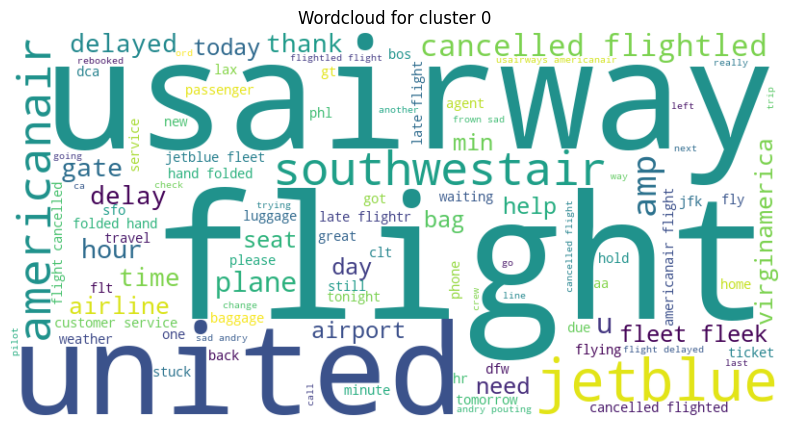

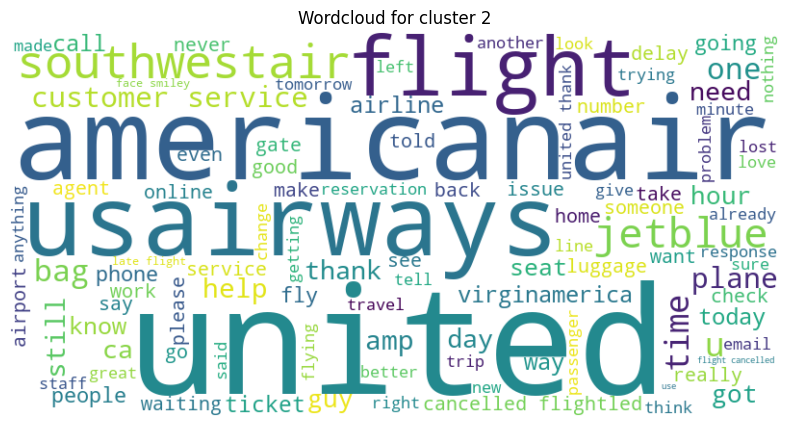

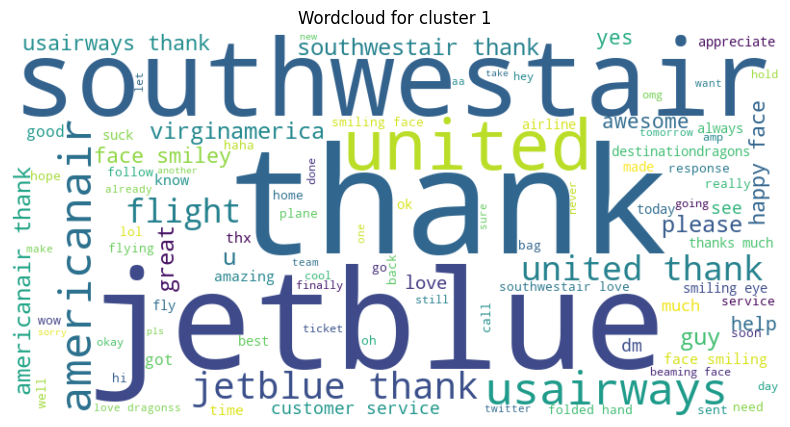

In [178]:
#plot the wordcloud for the bag of words model
plot_wordcloud(bag_of_words["processed_text"],clustering_results["kmeans_labels"])

From the wordcloud, several words appear across the 3 clusters.

What if our initial assumption that there are only 3 clusters is incorrect? As the bag of words model encodes much more information than just the sentiment, there might by multiple clusters. We use the elbow method to look at the optimal number of clusters in the dataset.

WCSSE (Inertia) for K=1: 150935.94849374972
WCSSE (Inertia) for K=2: 146719.11456328307
WCSSE (Inertia) for K=3: 143602.49019095633
WCSSE (Inertia) for K=4: 140427.43264083756
WCSSE (Inertia) for K=5: 139698.68621765455
WCSSE (Inertia) for K=6: 135475.65776432015
WCSSE (Inertia) for K=7: 135707.15812236728
WCSSE (Inertia) for K=8: 134379.46127352543
WCSSE (Inertia) for K=9: 132257.57587398466
WCSSE (Inertia) for K=10: 132290.54123621946
WCSSE (Inertia) for K=11: 131074.79199513397
WCSSE (Inertia) for K=12: 132135.29820698214
WCSSE (Inertia) for K=13: 130608.20613330342
WCSSE (Inertia) for K=14: 130648.45820401402
WCSSE (Inertia) for K=15: 130303.94290374822
WCSSE (Inertia) for K=16: 129543.51342372886
WCSSE (Inertia) for K=17: 130519.17336522408
WCSSE (Inertia) for K=18: 129873.21555415427
WCSSE (Inertia) for K=19: 129079.57022653255
WCSSE (Inertia) for K=20: 128736.45328214811


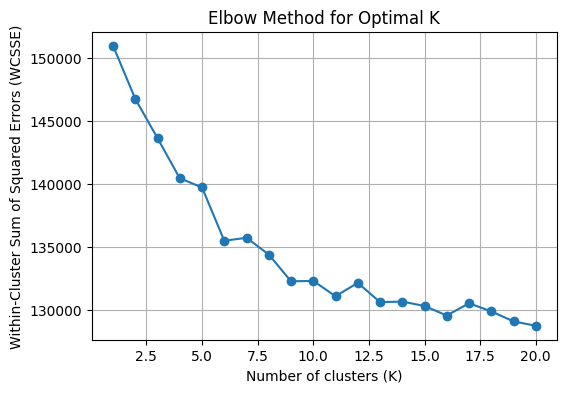

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Use Elbow Method to investigate whether there are more clusters
# Compute WCSSE for different values of K
wcsse = []
K_range = range(1, 21)
# runs Kmeans for k = 1 to 20
for k in tqdm(K_range):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_bag_of_words)
    wcsse.append(kmeans.inertia_)
    print(f"WCSSE (Inertia) for K={k}:", kmeans.inertia_)


# 3. Plot Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, wcsse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squared Errors (WCSSE)')
plt.grid(True)
plt.show()

### 4.2 Pre-trained text vectors and K-means

In [165]:
# For the spacy_vectors DataFrame that contains one column 'tweet_vectors' with lists
# Convert the lists to a numpy array and create a new DataFrame with numbered columns

# First stack the vectors into a 2D array
X_vectorized = np.vstack(spacy_vectors['tweet_vectors'].values)

# Create a new DataFrame with numbered columns
column_names = [f'vector_{i}' for i in range(X_vectorized.shape[1])]
spacy_vectors_expanded = pd.DataFrame(X_vectorized, columns=column_names)

#Preserve the index from original DataFrame:
spacy_vectors_expanded.index = spacy_vectors.index

In [180]:
k = 3
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
kmeans.fit(spacy_vectors_expanded)
# Cluster labels assigned to each data point (0, 1, or 2 for 3 clusters)
labels = kmeans.labels_

clustering_results=pd.DataFrame()
clustering_results["labels"]=tweet_data["airline_sentiment"]
clustering_results["labels_confidence"]=tweet_data["sentiment_confidence"]
clustering_results["kmeans_labels"]=labels
clustering_results.head(10)

,labels,labels_confidence,kmeans_labels
0,neutral,1.0000,0
1,positive,0.3486,2
2,neutral,0.6837,2
3,negative,1.0000,2
4,negative,1.0000,2
5,negative,1.0000,2
6,positive,0.6745,2
7,neutral,0.6340,2
8,positive,0.6559,1
9,positive,1.0000,2


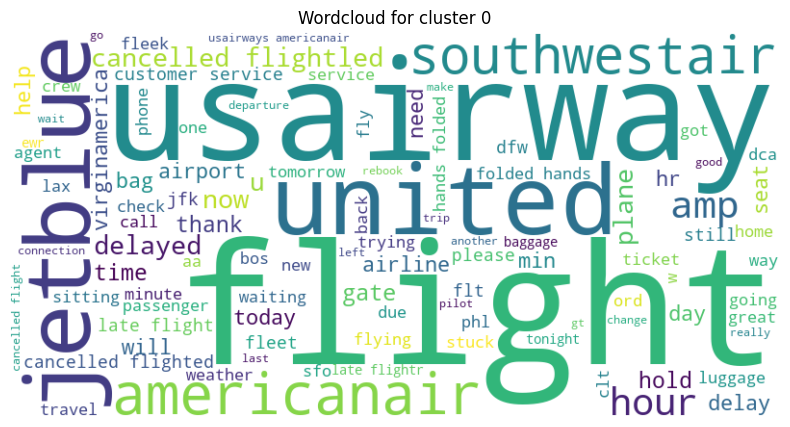

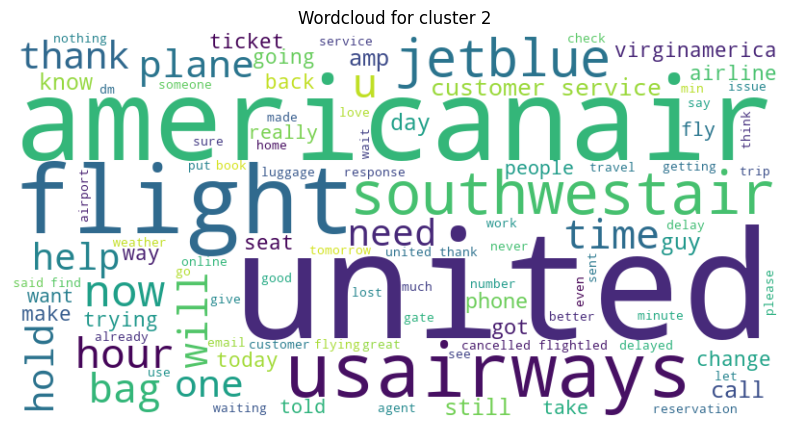

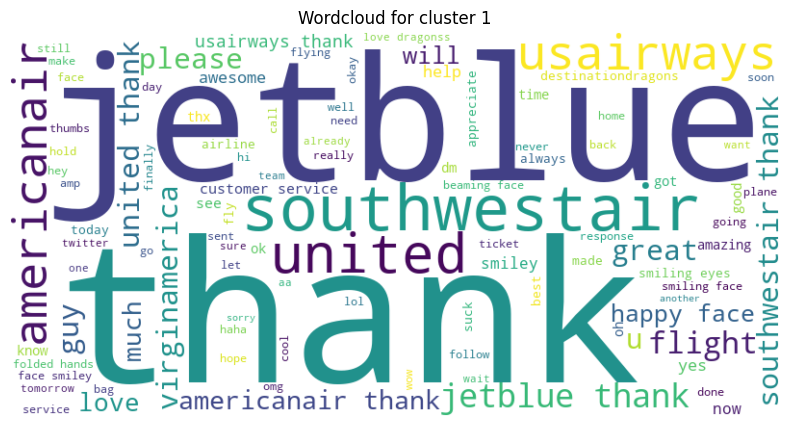

In [181]:
#plot the wordcloud
plot_wordcloud(cleaned_tweets["converted_text"], clustering_results["kmeans_labels"])

  5%|▌         | 1/20 [00:00<00:09,  1.93it/s]

WCSSE (Inertia) for K=1: 28750.126953125


 10%|█         | 2/20 [00:02<00:21,  1.18s/it]

WCSSE (Inertia) for K=2: 26350.2421875


 15%|█▌        | 3/20 [00:04<00:29,  1.76s/it]

WCSSE (Inertia) for K=3: 25199.390625


 20%|██        | 4/20 [00:07<00:37,  2.34s/it]

WCSSE (Inertia) for K=4: 24345.111328125


 25%|██▌       | 5/20 [00:11<00:44,  2.99s/it]

WCSSE (Inertia) for K=5: 23842.943359375


 30%|███       | 6/20 [00:16<00:48,  3.46s/it]

WCSSE (Inertia) for K=6: 23415.701171875


 35%|███▌      | 7/20 [00:21<00:52,  4.03s/it]

WCSSE (Inertia) for K=7: 23044.44921875


 40%|████      | 8/20 [00:27<00:55,  4.63s/it]

WCSSE (Inertia) for K=8: 22738.1015625


 45%|████▌     | 9/20 [00:34<00:57,  5.26s/it]

WCSSE (Inertia) for K=9: 22466.07421875


 50%|█████     | 10/20 [00:41<00:58,  5.88s/it]

WCSSE (Inertia) for K=10: 22230.044921875


 55%|█████▌    | 11/20 [00:49<00:57,  6.44s/it]

WCSSE (Inertia) for K=11: 22022.474609375


 60%|██████    | 12/20 [00:58<00:57,  7.25s/it]

WCSSE (Inertia) for K=12: 21793.955078125


 65%|██████▌   | 13/20 [01:07<00:54,  7.78s/it]

WCSSE (Inertia) for K=13: 21615.640625


 70%|███████   | 14/20 [01:19<00:55,  9.19s/it]

WCSSE (Inertia) for K=14: 21425.572265625


 75%|███████▌  | 15/20 [01:32<00:51, 10.23s/it]

WCSSE (Inertia) for K=15: 21285.30078125


 80%|████████  | 16/20 [01:49<00:49, 12.40s/it]

WCSSE (Inertia) for K=16: 21150.0234375


 85%|████████▌ | 17/20 [02:05<00:40, 13.34s/it]

WCSSE (Inertia) for K=17: 21020.12109375


 90%|█████████ | 18/20 [02:22<00:28, 14.44s/it]

WCSSE (Inertia) for K=18: 20904.259765625


 95%|█████████▌| 19/20 [02:32<00:13, 13.31s/it]

WCSSE (Inertia) for K=19: 20784.154296875


100%|██████████| 20/20 [02:51<00:00,  8.60s/it]

WCSSE (Inertia) for K=20: 20686.388671875


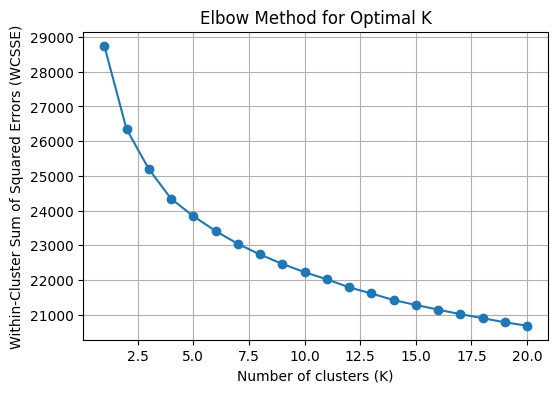

In [168]:
# Use Elbow Method to investigate whether there are more clusters
# Compute WCSSE for different values of K
wcsse = []
K_range = range(1, 21)
# runs Kmeans for k = 1 to 20
for k in tqdm(K_range):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(spacy_vectors_expanded)
    wcsse.append(kmeans.inertia_)
    print(f"WCSSE (Inertia) for K={k}:", kmeans.inertia_)


# 3. Plot Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, wcsse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squared Errors (WCSSE)')
plt.grid(True)
plt.show()

### 4.3 Specific features and K-means

In [182]:
k = 3
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
kmeans.fit(specific_features_encoded)
# Cluster labels assigned to each data point (0, 1, or 2 for 3 clusters)
labels = kmeans.labels_

clustering_results=pd.DataFrame()
clustering_results["labels"]=tweet_data["airline_sentiment"]
clustering_results["labels_confidence"]=tweet_data["sentiment_confidence"]
clustering_results["kmeans_labels"]=labels
clustering_results.head(10)

,labels,labels_confidence,kmeans_labels
0,neutral,1.0000,0
1,positive,0.3486,0
2,neutral,0.6837,0
3,negative,1.0000,1
4,negative,1.0000,1
5,negative,1.0000,1
6,positive,0.6745,0
7,neutral,0.6340,1
8,positive,0.6559,0
9,positive,1.0000,1


In [186]:
pos_est=clustering_results["kmeans_labels"][(clustering_results["labels"]=="positive") & 
                                            (clustering_results["labels_confidence"]>0.9)].mode()
neu_est=clustering_results["kmeans_labels"][(clustering_results["labels"]=="neutral") & 
                                            (clustering_results["labels_confidence"]>0.9)].mode()
neg_est=clustering_results["kmeans_labels"][(clustering_results["labels"]=="negative") & 
                                            (clustering_results["labels_confidence"]>0.9)].mode()

print(f"Mode kmeans label for positive sentiment: {pos_est[0]}")
print(f"Mode kmeans label for neutral sentiment: {neu_est[0]}")
print(f"Mode kmeans label for negative sentiment: {neg_est[0]}")

Mode kmeans label for positive sentiment: 1
Mode kmeans label for neutral sentiment: 0
Mode kmeans label for negative sentiment: 0


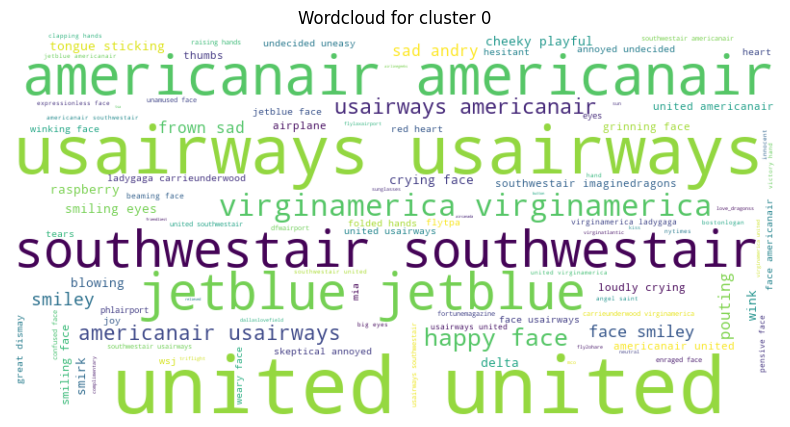

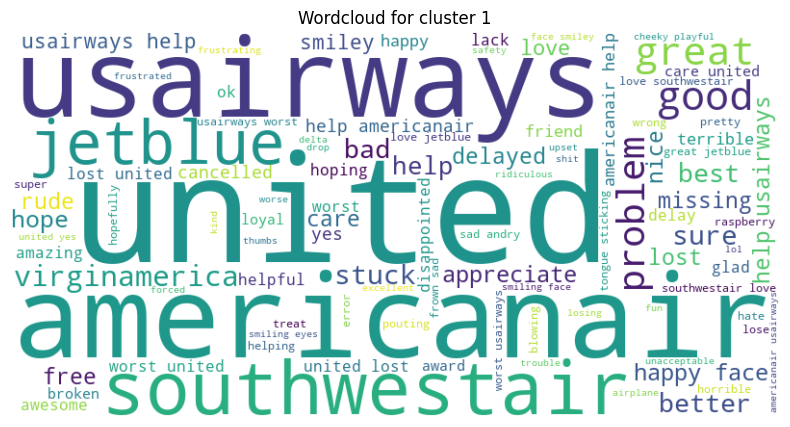

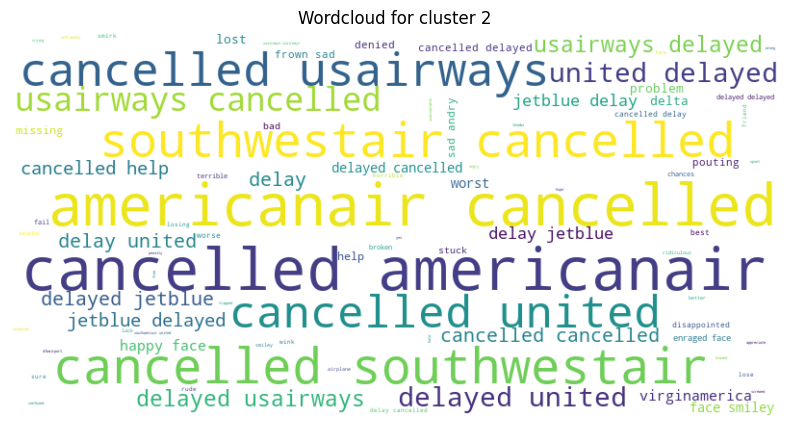

In [185]:
#plot the wordcloud
#the text should only be those used for the encoding
def combine_features(row):
    # Convert each list to strings and join with spaces
    handles_str = ' '.join(row['handles']) if row['handles'] else ''
    emojis_str = ' '.join(row['emojis_emoticons']) if row['emojis_emoticons'] else ''
    sentiment_str = ' '.join(row['sentiment_words']) if row['sentiment_words'] else ''
    
    # Combine all strings with spaces
    combined = ' '.join(filter(None, [handles_str, emojis_str, sentiment_str]))
    return combined

# Apply the function to create a new column with combined features
specific_features['combined_features'] = specific_features.apply(combine_features, axis=1)

plot_wordcloud(specific_features['combined_features'] , clustering_results["kmeans_labels"])

In [ ]:
#Run the elbow method again but using only the VADER words

# Use Elbow Method to investigate whether there are more clusters
# Compute WCSSE for different values of K
wcsse = []
K_range = range(1, 21)
# runs Kmeans for k = 1 to 20
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_vader)
    wcsse.append(kmeans.inertia_)
    print(f"WCSSE (Inertia) for K={k}:", kmeans.inertia_)


# 3. Plot Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, wcsse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squared Errors (WCSSE)')
plt.grid(True)
plt.show()

WCSSE (Inertia) for K=1: 28750.126953125
WCSSE (Inertia) for K=2: 26350.2421875
WCSSE (Inertia) for K=3: 25199.390625
WCSSE (Inertia) for K=4: 24345.11328125
WCSSE (Inertia) for K=5: 23842.943359375
WCSSE (Inertia) for K=6: 23415.701171875
WCSSE (Inertia) for K=7: 23044.44921875
WCSSE (Inertia) for K=8: 22738.1015625
WCSSE (Inertia) for K=9: 22466.07421875
WCSSE (Inertia) for K=10: 22230.044921875
WCSSE (Inertia) for K=11: 22022.47265625
WCSSE (Inertia) for K=12: 21793.955078125
WCSSE (Inertia) for K=13: 21615.640625
WCSSE (Inertia) for K=14: 21425.572265625
WCSSE (Inertia) for K=15: 21285.30078125
WCSSE (Inertia) for K=16: 21150.0234375
WCSSE (Inertia) for K=17: 21020.12109375
WCSSE (Inertia) for K=18: 20904.259765625
WCSSE (Inertia) for K=19: 20784.154296875
WCSSE (Inertia) for K=20: 20686.388671875


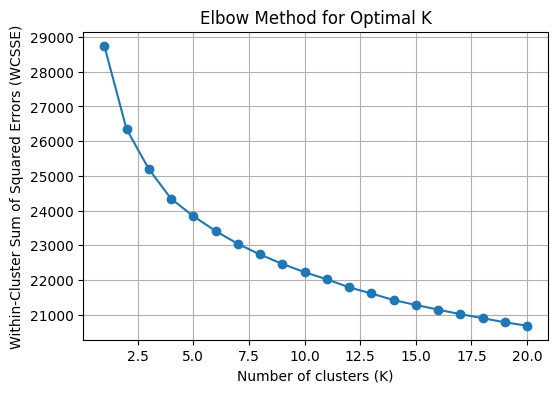

In [99]:
#Try k-means again using the tweet vectors instead of BoW

X_vectorized = np.vstack(spacy_vectors['tweet_vectors'].values)

# Use Elbow Method to investigate whether there are more clusters
# Compute WCSSE for different values of K
wcsse = []
K_range = range(1, 21)
# runs Kmeans for k = 1 to 20
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_vectorized)
    wcsse.append(kmeans.inertia_)
    print(f"WCSSE (Inertia) for K={k}:", kmeans.inertia_)


# 3. Plot Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, wcsse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squared Errors (WCSSE)')
plt.grid(True)
plt.show()

### 4.4 VADER sentiments and K-means

WCSSE (Inertia) for K=1: 4395.952110506963
WCSSE (Inertia) for K=2: 1661.3655499141214
WCSSE (Inertia) for K=3: 1002.869986224907
WCSSE (Inertia) for K=4: 715.1305193832316
WCSSE (Inertia) for K=5: 588.210017089156
WCSSE (Inertia) for K=6: 478.3758917320632
WCSSE (Inertia) for K=7: 400.0916347703542
WCSSE (Inertia) for K=8: 358.06114168627226
WCSSE (Inertia) for K=9: 321.19224474264513
WCSSE (Inertia) for K=10: 287.08667111236264
WCSSE (Inertia) for K=11: 257.5191512427781
WCSSE (Inertia) for K=12: 239.356711764849
WCSSE (Inertia) for K=13: 221.4970574238423
WCSSE (Inertia) for K=14: 206.0613743400471
WCSSE (Inertia) for K=15: 191.84753949245115
WCSSE (Inertia) for K=16: 180.14898286690348
WCSSE (Inertia) for K=17: 170.78696963814232
WCSSE (Inertia) for K=18: 162.78723167063185
WCSSE (Inertia) for K=19: 154.68719157815258
WCSSE (Inertia) for K=20: 148.80729150666207


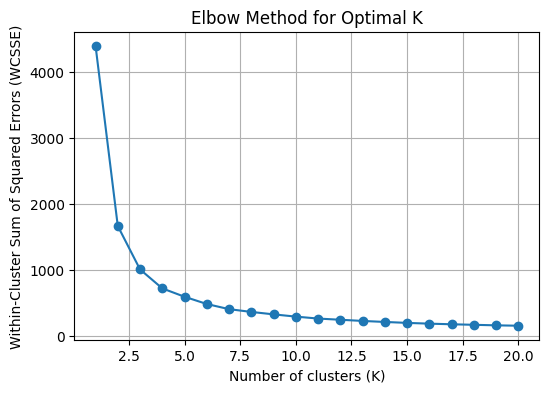

In [187]:
#Try k-means with the VADER sentiments

# Use Elbow Method to investigate whether there are more clusters
# Compute WCSSE for different values of K
wcsse = []
K_range = range(1, 21)
# runs Kmeans for k = 1 to 20
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(VADER_sentiments)
    wcsse.append(kmeans.inertia_)
    print(f"WCSSE (Inertia) for K={k}:", kmeans.inertia_)


# 3. Plot Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, wcsse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squared Errors (WCSSE)')
plt.grid(True)
plt.show()

WCSSE (Inertia): 1002.9789984875345


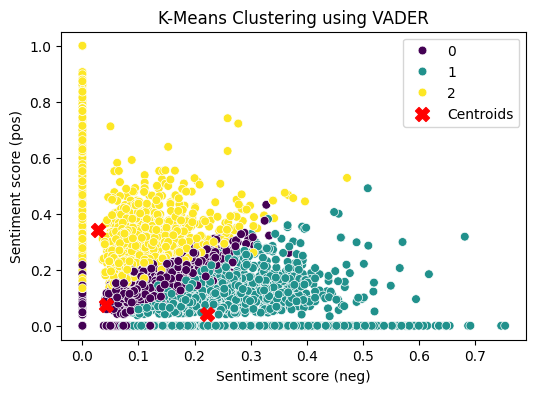

In [188]:
import seaborn as sns

k = 3
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
kmeans.fit(VADER_sentiments)
# Cluster labels assigned to each data point (0, 1, or 2 for 3 clusters)
labels = kmeans.labels_

print("WCSSE (Inertia):", kmeans.inertia_)

# Create DataFrame for plotting
df_plot = pd.DataFrame(VADER_sentiments, columns=["neg","pos"])
df_plot['Cluster'] = labels

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_plot,
                x="neg",
                y="pos",
                hue='Cluster',
                palette='viridis',
                s=40)

# Plot centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 2],
            s=100, c='red', marker='X', label='Centroids')

plt.title("K-Means Clustering using VADER")
plt.xlabel("Sentiment score (neg)")
plt.ylabel("Sentiment score (pos)")
plt.legend()
plt.show()

Weakness of k-means clustering: sensitive to outliers, which might be the case here. We try using DBSCAN (Density-Based Spatial Clustering of Applications with Noise), which finds arbitary shaped points and clusters.

DBSCAN does not require K clusters initially. Instead, it requires two parameters: eps and minPts.

eps: it is the radius of specific neighborhoods. If the distance between two points is less than or equal to esp, it will be considered its neighbors.
minPts: minimum number of data points in a given neighborhood to form the clusters. 
DBSCAN uses these two parameters to define a core point, border point, or outlier.

https://www.kdnuggets.com/2022/08/implementing-dbscan-python.html


In [ ]:
#An important parameter for DBSCAN is the epsilon neighbourhood distance
#To estimate a good value for epsilon, we can plot the k-distance graph
#And look for the "elbow" point in the graph

#X_vader

from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(X_vectorized)
distances, indices = neighbors_fit.kneighbors(X_vectorized)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
from sklearn.cluster import DBSCAN

# Initialize DBSCAN with chosen eps and minPts
dbscan = DBSCAN(eps=10000, min_samples=3) # Adjust eps and min_samples as needed

# Fit the model to the data and get cluster labels
clusters = dbscan.fit_predict(X_vectorized)

In [ ]:
print(clusters.max())

Check accuracy of clustering against dataset "airline_sentiment" column

In [ ]:
#Check accuracy of clustering against dataset "airline_sentiment" column
#Check that the accuracy correlates against the "confidence" column,
# ie. the misrepresented tweets are those that have low confidence scores
# and those that are correct should have high confidence

## Step 5: Something special

From the literature review, we discovered that it's possible for a single tweet to have both positive and negative sentiments when describing different things. Hence, we investigate to what extent this might be true in the dataset, and whether that could have caused some of the misclassified samples.